# Analyzing price drop periods

In [205]:
import pandas as pd
from importlib import reload
import numpy as np
import datetime
import math
import sys

import common
reload(common)
import moving
reload(moving)
import render
reload(render)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading stocks prices history from './history' folder

In [206]:
history = common.load_history('./history')
stocks = pd.read_csv('data/stocks.tcs', index_col=0)

583 files with prices hoistory found
583 files with prices hoistory loaded
111113 items totaly since 2000-02-29 00:00:00 to 2018-07-24 00:00:00


## Ignore symbols younger than 2016

In [207]:
ignored = common.younger_than(history)
history = common.older_than(history)
print('{} symbols ignored: {}'.format(len(ignored), ignored.keys()))

22 symbols ignored: dict_keys(['AA', 'APY', 'BGIO', 'BHF', 'BHGE', 'CBH', 'CBRE', 'DHCP', 'DLPH', 'DWDP', 'DXC', 'FTV', 'HGV', 'MFGP', 'MGNT', 'MOSC', 'PRSP', 'UA', 'VNE-WI', 'WELL', 'WH', 'WLTW'])


## Extract periods and append columns 'price-ratio', 'max-prev', 'price-drop', 'drop-period', 'price-growth'

Here each symbol history divided in few periods to study them separately and to compare them.
Periods are:
    - all history
    - middle 50% of hostry
    - first 25% of histry
    - first 50% of histry
    - first 75% of histry    
    - last 75% of hostry
    - last 50% of hostry
    - last 25% of hostry
    - last N years of history (symbols younger N years excluded) where N in [2, 3, 5, 7, 10, 15]

In [208]:
def before_now(years):
    return pd.datetime.now() - pd.Timedelta('{} days'.format(365 * years))

# periods = [('first-25', (0.,0.25)), ('first-50', (0.,0.5)), ('first-75', (0.,0.75)), ('all', (0.,1.)),
#            ('middle-50', (0.25,0.75)), ('last-75', (0.25,1.)), ('last-50', (0.5,1.)), ('last-25', (0.75,1.))]
now = pd.datetime.now()
# abs_periods = [('last-15y', (before_now(15), now)), ('last-10y', (before_now(10), now)), 
#                ('last-7y', (before_now(7), now)), ('last-5y', (before_now(5), now)),
#                ('last-3y', (before_now(3), now)), ('last-2y', (before_now(2), now))]
periods = [('all', (0.,1.))]
abs_periods = [('last-15y', (before_now(15), now))]

In [209]:
hist_per = {}
for (p_name, period) in periods:
    hp = common.prepare_history_period(history, period[0], period[1])
    hist_per[p_name] = hp
    
for (p_name, period) in abs_periods:
    hp = common.prepare_history_abs_period(history, period[0], period[1])
    hist_per[p_name] = hp

### Append column with price ratio to symbol history.

Price ratio value for current date is a ratio of current close price to first open price in symbol history

### Append columns with max price ratio for previous periods

Max price ratio value for current date is a maximum price ratio since begin of symbol history to current date inclusivle 

### Append column with price drop after last maximum

Price drop value for current date is ratio of current price ratio to current max price ratio. It shows depth of price fall since last price maximum.

### Append column with price drop period in days

Price drop period  for current date is number of days passed since last price maximum.

### Append column with average price growth ratio for last 1, 2, 3, 4 and 5 years

Average price growth ratio value for current date is ratio of current close price to open price at begin of time window averaged for specified period

### Append column with minimal price ratio for each price drop period

Minimal price ratio value for current date is minimal price ratio value since begin of currnet price drop period or just current price ratio if there is no drop now

In [210]:
for (p_name, hp) in hist_per.items():
    common.append_price_ratio_column(hp)
    common.append_max_prev_column(hp)
    common.append_price_drop_column(hp)
    common.append_drop_period_column(hp)
    common.append_price_grouth_column(hp, windows = range(1,6))
#     common.append_drop_min_column(hp)
    print('Period "{}" - OK'.format(p_name))

Period "all" - OK
Period "last-15y" - OK


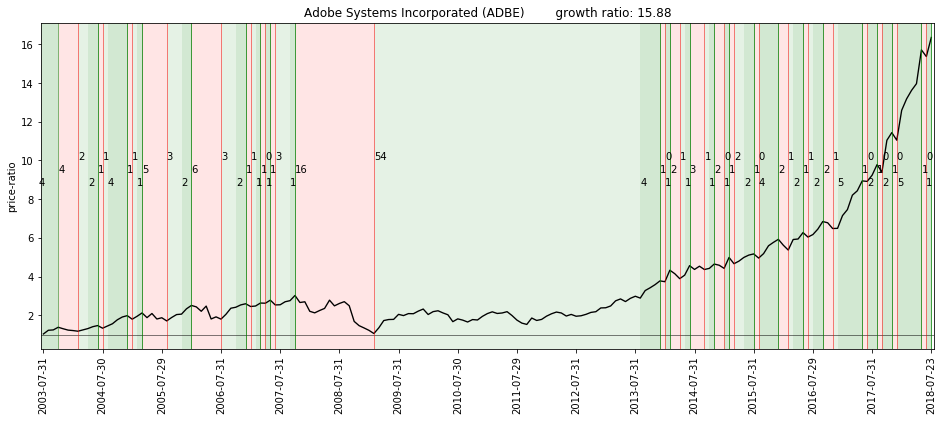

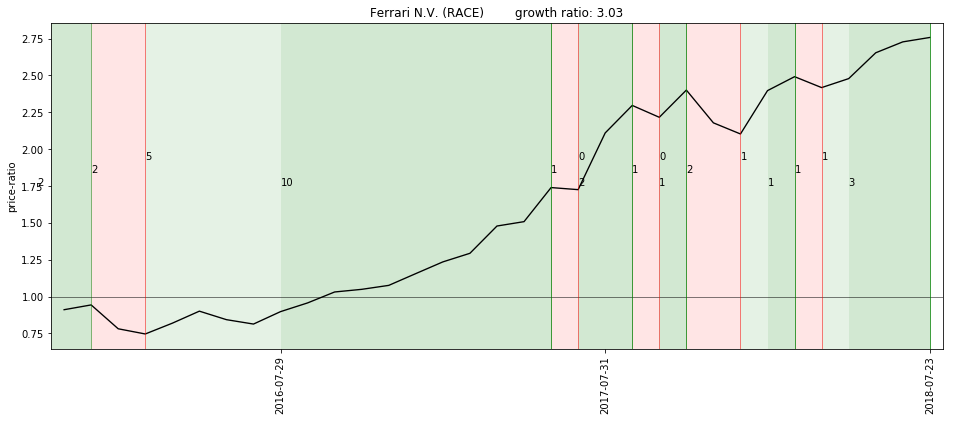

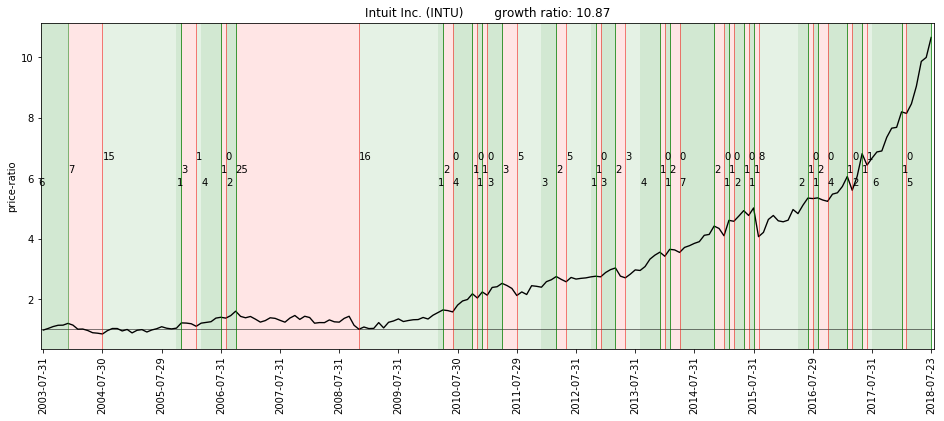

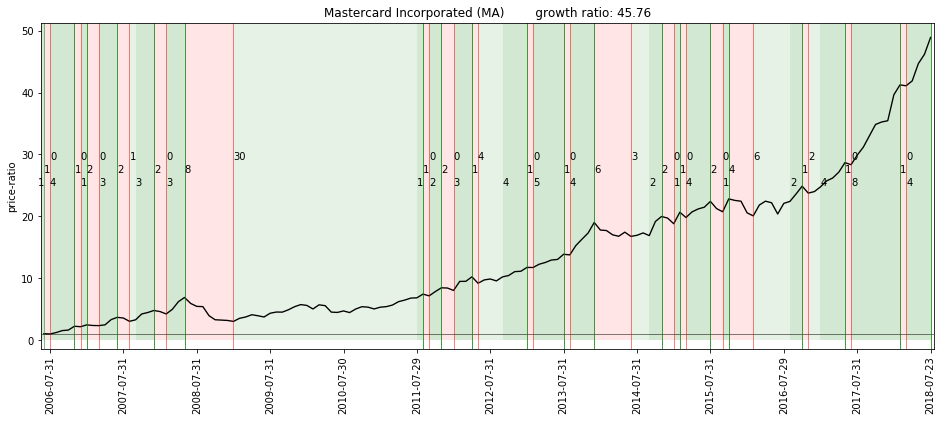

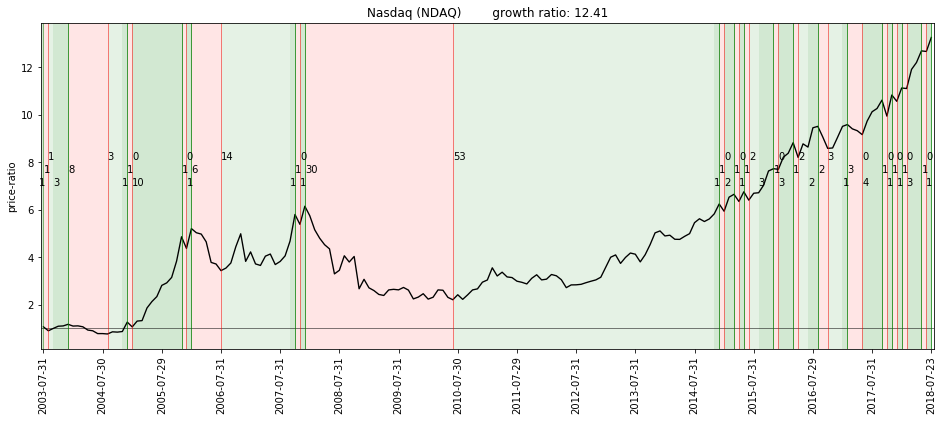

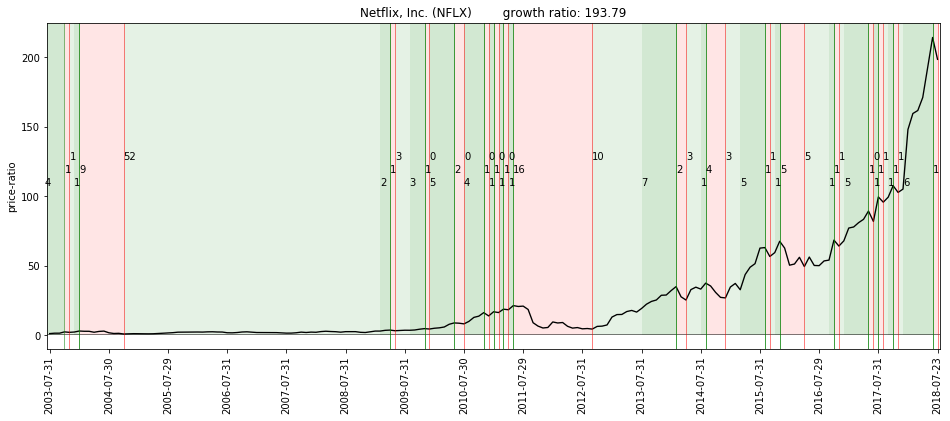

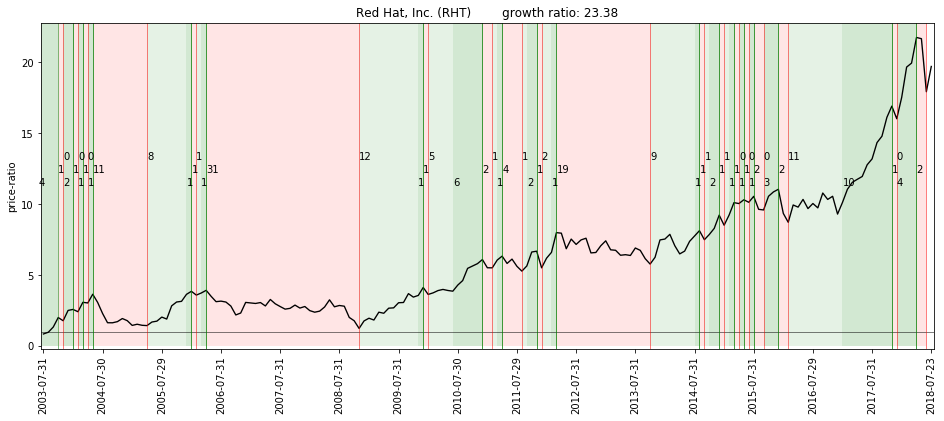

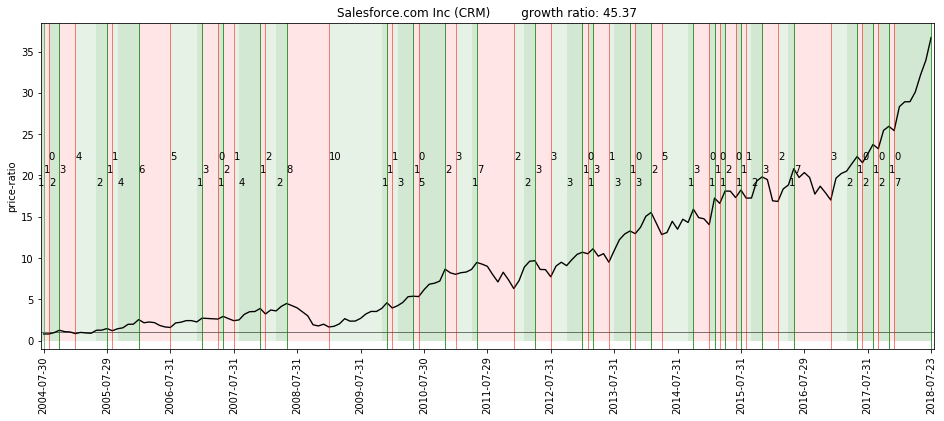

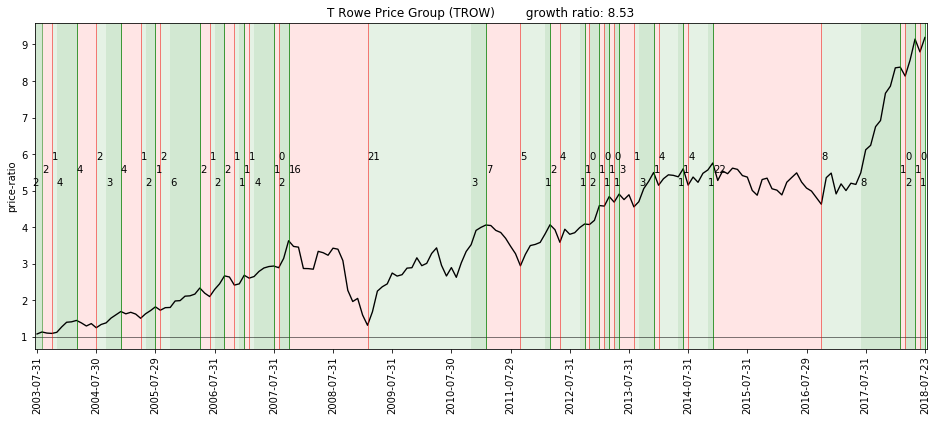

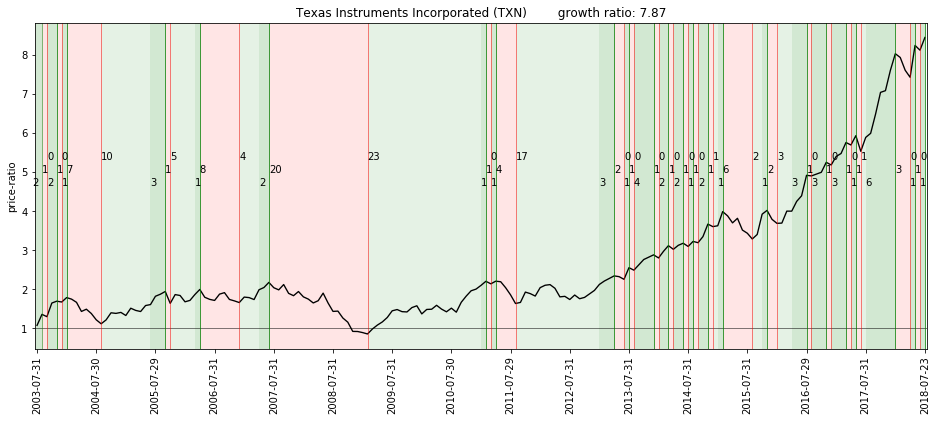

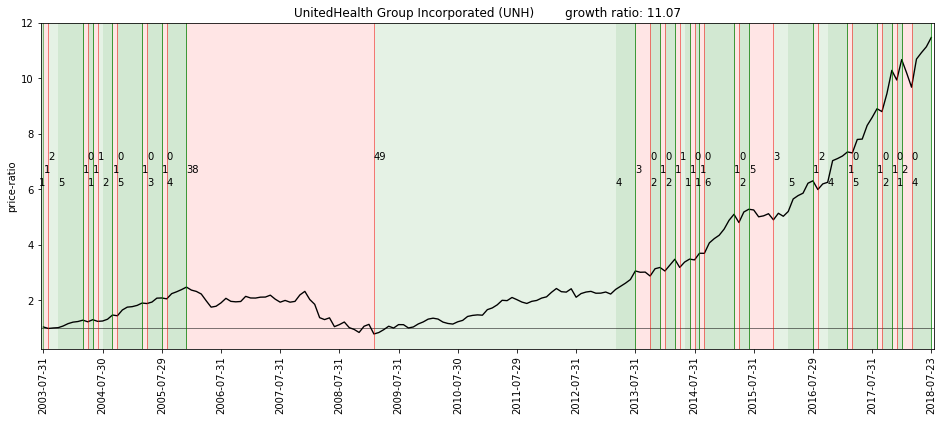

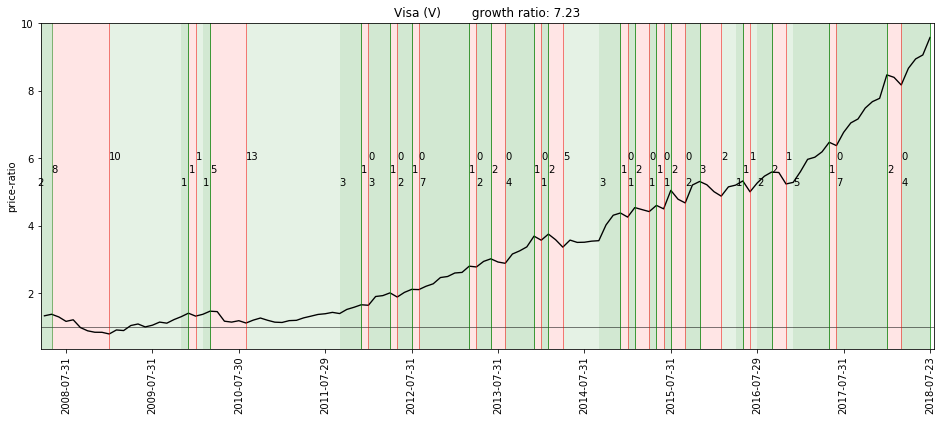

In [212]:
reload(render)
shortlist = [*map(lambda s: s.strip(), open('data/shortlist').readlines())]
for symbol in shortlist:
    if symbol in hist_per['last-15y']:
        hp = hist_per['last-15y']
    else:
        hp = hist_per['all']
    render.draw_column(hp, symbol, stocks['Name'][symbol], column = 'price-ratio', add = ['periods', 'periods-labels'])

In [213]:
daily = common.load_history('./history_daily')
stocks = pd.read_csv('data/stocks.tcs', index_col=0)

513 files with prices hoistory found
513 files with prices hoistory loaded
51215 items totaly since 2017-12-29 00:00:00 to 2018-07-24 00:00:00


In [214]:
daily_per = {'all': daily}
for (p_name, hp) in daily_per.items():
    common.append_price_ratio_column(hp)
    common.append_max_prev_column(hp)
    common.append_price_drop_column(hp)
    common.append_drop_period_column(hp)
    common.append_price_grouth_column(hp, windows = [])
    print('Period "{}" - OK'.format(p_name))

Period "all" - OK


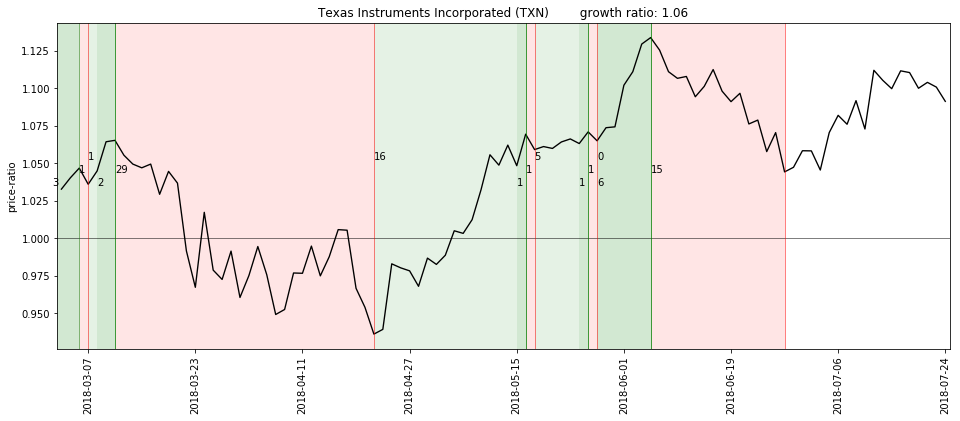

[1, 29, 1, 1, 15]


/Users/fedor/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


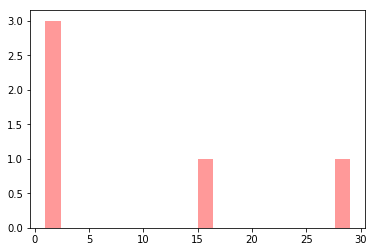

[2, 17, 6, 1]


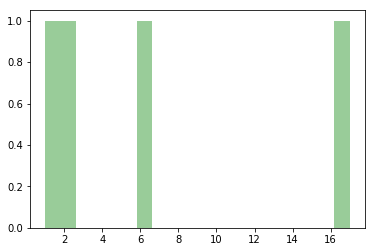

In [215]:
reload(render)
reload(common)
hp = daily_per['all']
symbol = 'TXN'
h = hp[symbol]
p = common.periods(hp[symbol])
render.draw_column(hp, symbol, stocks['Name'][symbol], column = 'price-ratio', add = ['periods', 'periods-labels'])

values = []
for index, row in p[p['type'] == 'drop'].iterrows():
    period = h.index.get_loc(row['end']) - h.index.get_loc(row['begin']) + 1
    values.append(period)
print(values)
sns.distplot(values, bins=20, kde=False, label='', color='red')

plt.show()
values = []
for index, row in p[p['type'] == 'growth'].iterrows():
    period = h.index.get_loc(row['end']) - h.index.get_loc(row['begin']) + 1
    values.append(period)
print(values)
sns.distplot(values, bins=20, kde=False, label='', color='green')

plt.show()



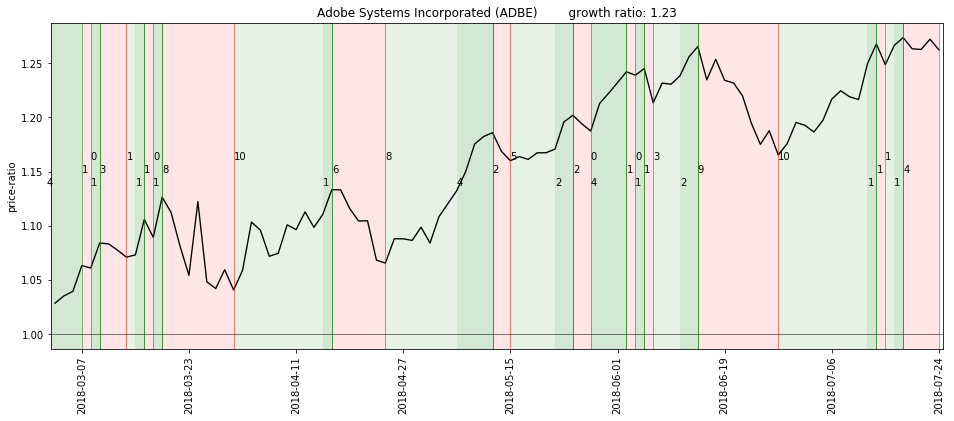

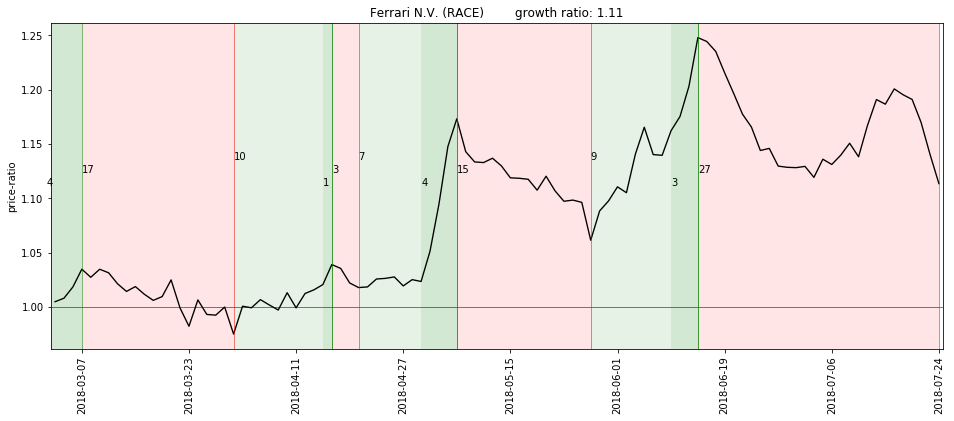

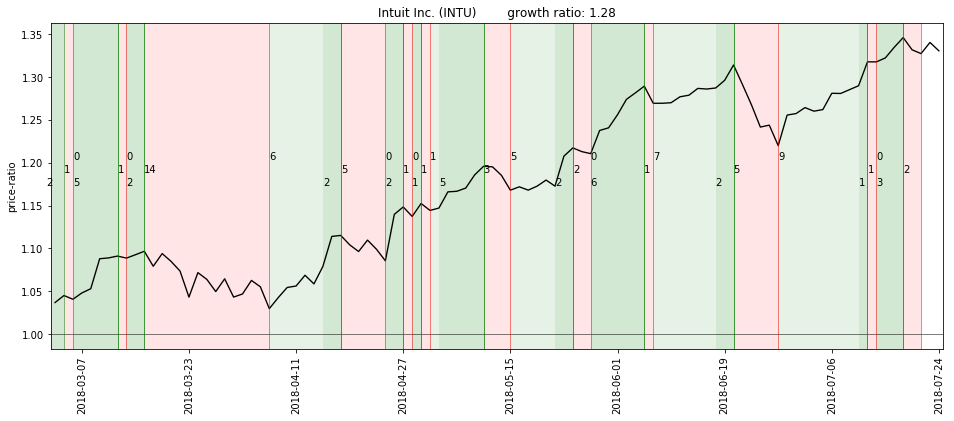

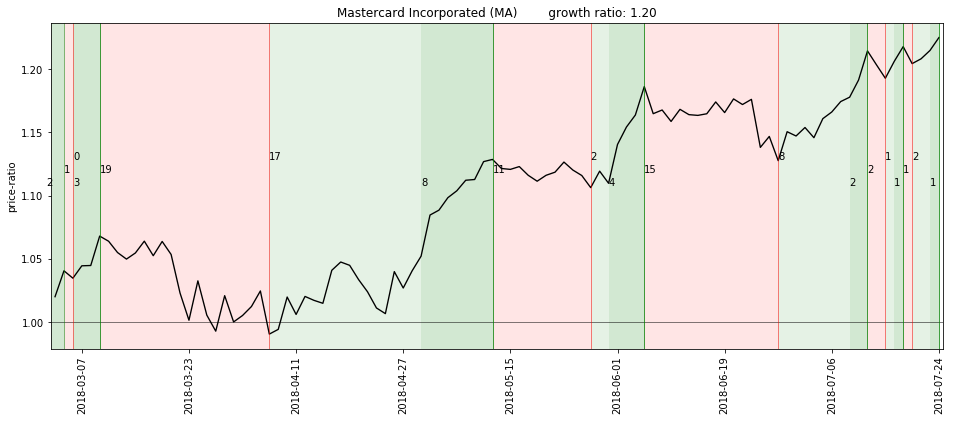

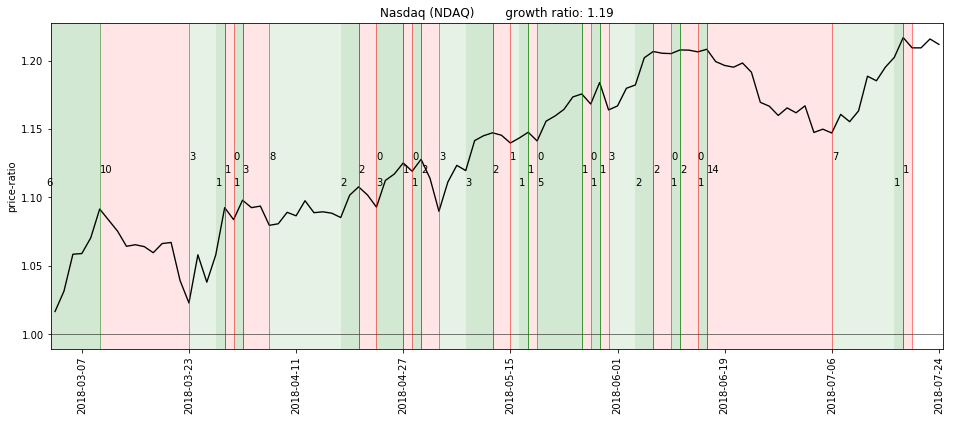

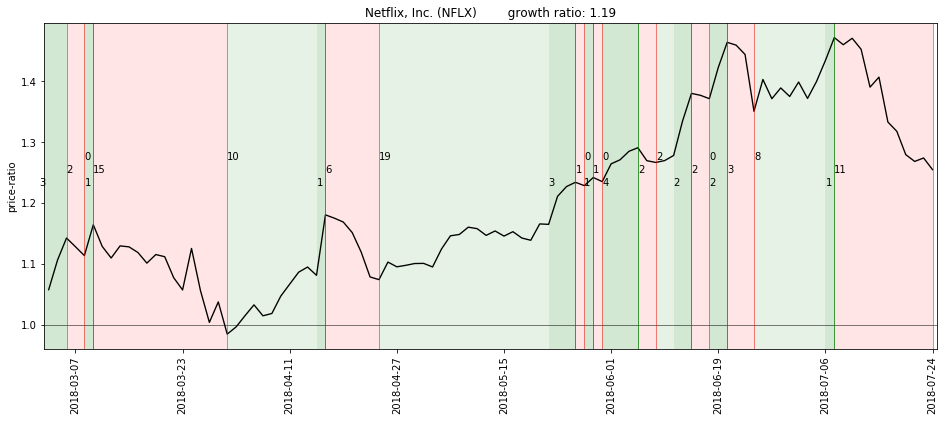

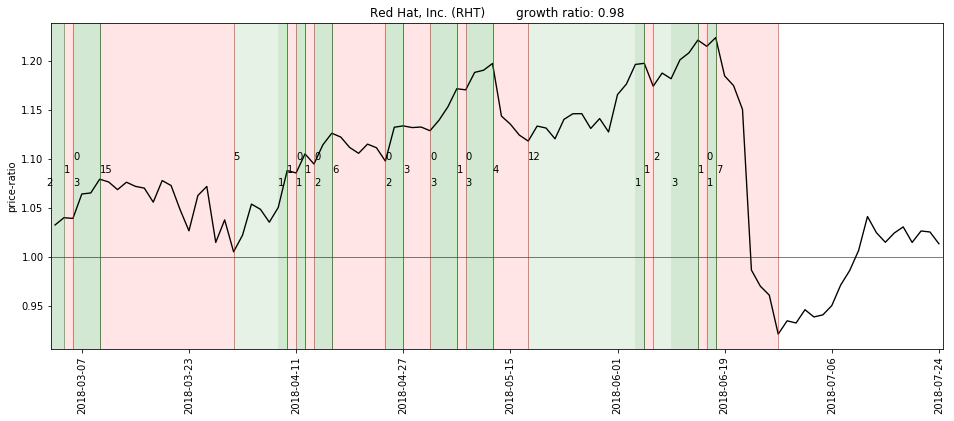

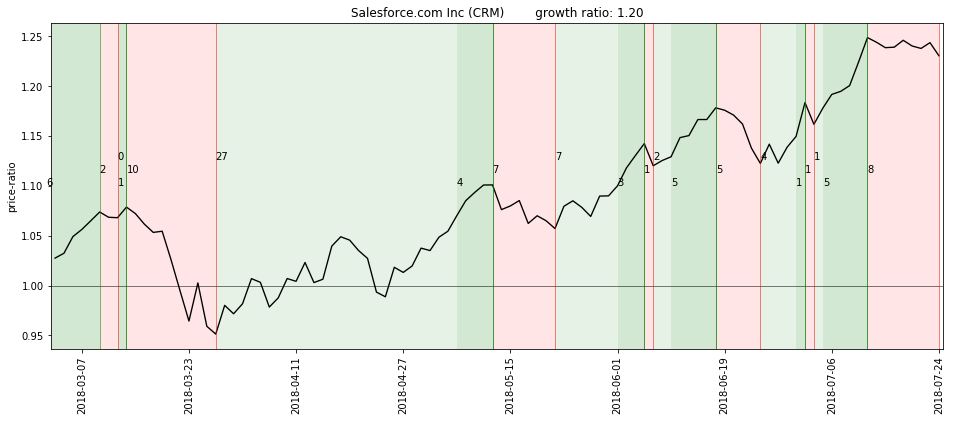

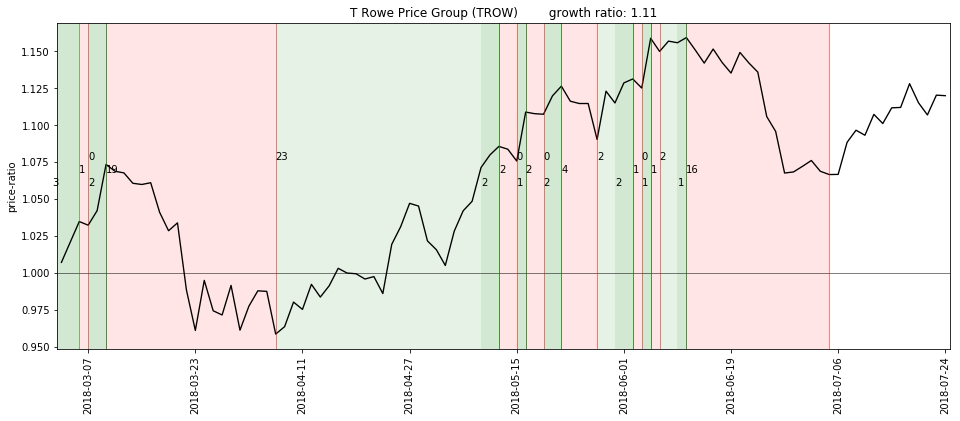

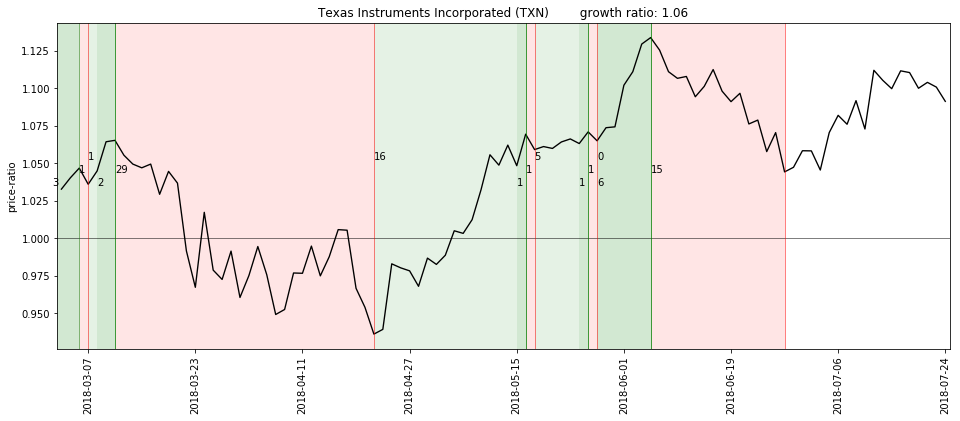

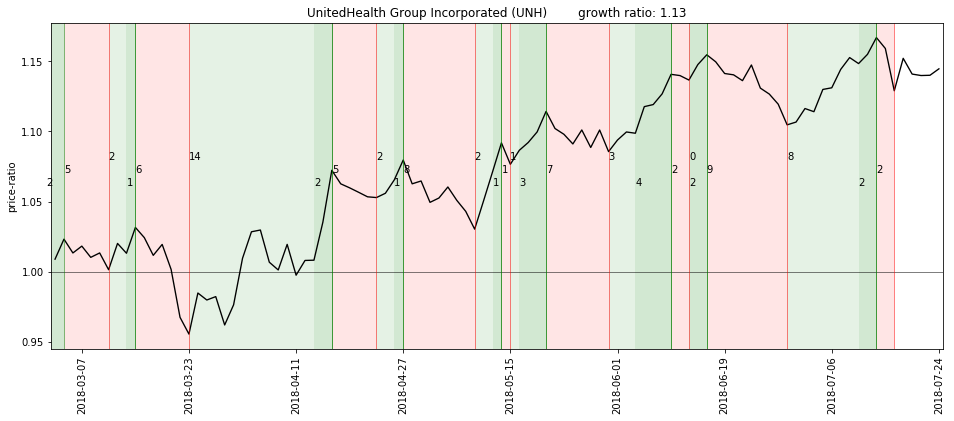

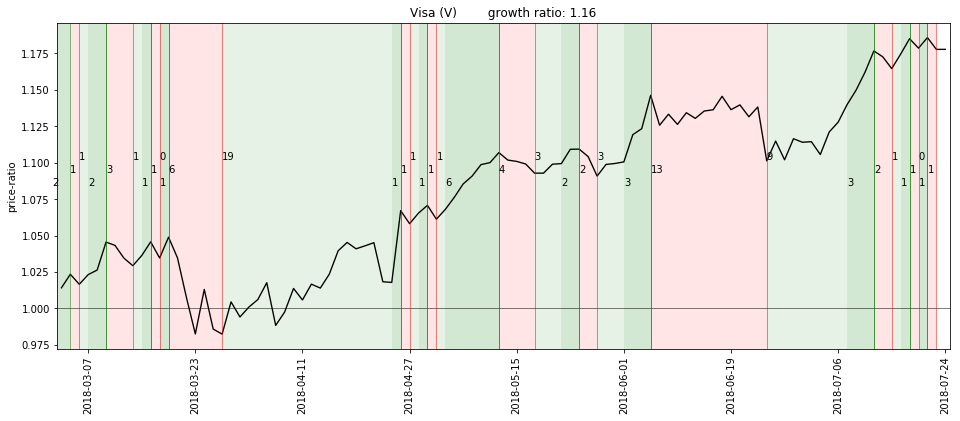

In [216]:
reload(render)
shortlist = [*map(lambda s: s.strip(), open('data/shortlist').readlines())]
for symbol in shortlist:
    hp = daily_per['all']
    render.draw_column(hp, symbol, stocks['Name'][symbol], column = 'price-ratio', add = ['periods', 'periods-labels'])